In [182]:
import numpy as np
import pandas as pd

np.random.seed(27)

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.__version__)

physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

Num GPUs Available:  0
2.9.0


In [183]:
import openaq
# Import Meteostat library and dependencies
#from meteostat import Point, Hourly, Daily

openaq = openaq.OpenAQ(version="v2")

In [184]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings("ignore")

In [185]:
# Import data using datetime and set index to datetime
df = pd.read_csv(r'C:\Users\91783\Desktop\DataSet\1_Bhiwadi\Book_1_PM.csv',
                                parse_dates=['Date'],
                                index_col=['Date'])

df.head()

,pm25
Date,
2021-01-01,228.53
2021-02-01,222.37
2021-03-01,128.14
2021-04-01,68.44
2021-05-01,62.51


In [186]:
df

,pm25
Date,
2021-01-01,228.53
2021-02-01,222.37
2021-03-01,128.14
2021-04-01,68.44
2021-05-01,62.51
...,...
2021-12-27,92.11
2021-12-28,124.25
2021-12-29,105.15


In [187]:
from sklearn.model_selection import train_test_split

# ["pm25","pm10","no2","o3","so2","co","temp","rhum","wspd","pres","pm25_AQI","pm10_AQI","no2_AQI","o3_AQI","so2_AQI","overall_AQI", "row_index"]

features=df.values
targets=df[["pm25"]].values

X_train, X_test, y_train, y_test  = train_test_split(features, targets, test_size=0.1, random_state=1, shuffle=False)

X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size=0.1, random_state=1, shuffle=False)

print("features:", features.shape)
print("targets:", targets.shape)

print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("X_val:", X_val.shape)

print("y_train:", y_train.shape)
print("y_test:", y_test.shape)
print("y_val:", y_val.shape)

features: (365, 1)
targets: (365, 1)
X_train: (295, 1)
X_test: (37, 1)
X_val: (33, 1)
y_train: (295, 1)
y_test: (37, 1)
y_val: (33, 1)


In [188]:
from datetime import datetime, timedelta
import time


In [189]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)

X_val = scaler.transform(X_val)

X_test = scaler.transform(X_test)

X_train.shape, X_test.shape

((295, 1), (37, 1))

In [190]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

win_length=12
batch_size=4
num_features=features.shape[1]

train_generator = TimeseriesGenerator(X_train, y_train, length=win_length, sampling_rate=1, batch_size=batch_size)
val_generator = TimeseriesGenerator(X_val, y_val, length=win_length, sampling_rate=1, batch_size=batch_size)
test_generator = TimeseriesGenerator(X_test, y_test, length=win_length, sampling_rate=1, batch_size=batch_size)

In [191]:

model_LSTM = tf.keras.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100,  return_sequences=True), input_shape=(win_length, num_features)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, return_sequences=False)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(targets.shape[1])
])

model_LSTM.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001), loss=tf.losses.MeanSquaredLogarithmicError())

tf.keras.utils.plot_model(model=model_LSTM, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [ ]:
lr_monitor = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.5, cooldown=1)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True)

with tf.device('/GPU:0'):
    prepared_model = model_LSTM.fit(train_generator, 
                                    validation_data=val_generator,
                                    epochs=200, 
                                    shuffle=False,  
                                    callbacks=[lr_monitor, early_stopping])

Epoch 1/200
71/71 [==============================] - 7s 32ms/step - loss: 4.6441 - val_loss: 4.4844 - lr: 0.0010
Epoch 2/200
71/71 [==============================] - 1s 19ms/step - loss: 1.5168 - val_loss: 3.5245 - lr: 0.0010
Epoch 3/200
71/71 [==============================] - 1s 20ms/step - loss: 1.1226 - val_loss: 2.9585 - lr: 0.0010
Epoch 4/200
71/71 [==============================] - 1s 19ms/step - loss: 0.8933 - val_loss: 2.5738 - lr: 0.0010
Epoch 5/200
71/71 [==============================] - 1s 21ms/step - loss: 0.7451 - val_loss: 2.2921 - lr: 0.0010
Epoch 6/200
71/71 [==============================] - 1s 20ms/step - loss: 0.6471 - val_loss: 2.0747 - lr: 0.0010
Epoch 7/200
71/71 [==============================] - 1s 19ms/step - loss: 0.5727 - val_loss: 1.9018 - lr: 0.0010
Epoch 8/200
71/71 [==============================] - 2s 22ms/step - loss: 0.5110 - val_loss: 1.7614 - lr: 0.0010
Epoch 9/200
71/71 [==============================] - 1s 19ms/step - loss: 0.4646 - val_loss: 1.6

Text(0, 0.5, 'mse score')

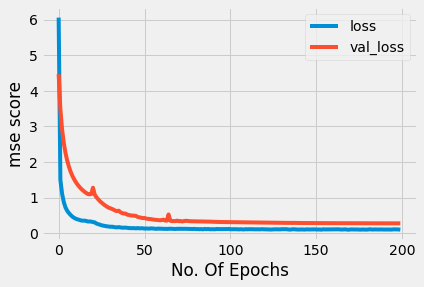

In [152]:
plt.plot(prepared_model.history["loss"],label="loss")
plt.plot(prepared_model.history["val_loss"],label="val_loss")
plt.legend(loc="best")
plt.xlabel("No. Of Epochs")
plt.ylabel("mse score")

In [153]:
model_LSTM.evaluate(test_generator, verbose=1)

7/7 [==============================] - 0s 4ms/step - loss: 0.1266


0.12664838135242462

In [154]:
predictions=model_LSTM.predict(test_generator)

pd.DataFrame(predictions)

7/7 [==============================] - 1s 6ms/step


,0
0,128.402222
1,92.914757
2,79.583855
3,80.503098
4,95.223511
5,92.961258
6,93.601181
7,131.030380
8,128.393402
9,131.528198


In [155]:
df_pred=pd.DataFrame(X_test[:,:][win_length:])

rev_trans=scaler.inverse_transform(df_pred)

df_final=df[rev_trans.shape[0]*-1:]
df_final

,pm25
Date,
2021-07-12,71.90
2021-08-12,67.50
2021-09-12,85.79
2021-10-12,100.69
2021-11-12,89.37
2021-12-12,91.58
2021-12-13,158.47
2021-12-14,137.51
2021-12-15,172.90


In [156]:
df_final[["pm25_pred"]]=predictions
df_final

,pm25,pm25_pred
Date,,
2021-07-12,71.90,128.402222
2021-08-12,67.50,92.914757
2021-09-12,85.79,79.583855
2021-10-12,100.69,80.503098
2021-11-12,89.37,95.223511
2021-12-12,91.58,92.961258
2021-12-13,158.47,93.601181
2021-12-14,137.51,131.030380
2021-12-15,172.90,128.393402


<AxesSubplot:xlabel='Date'>

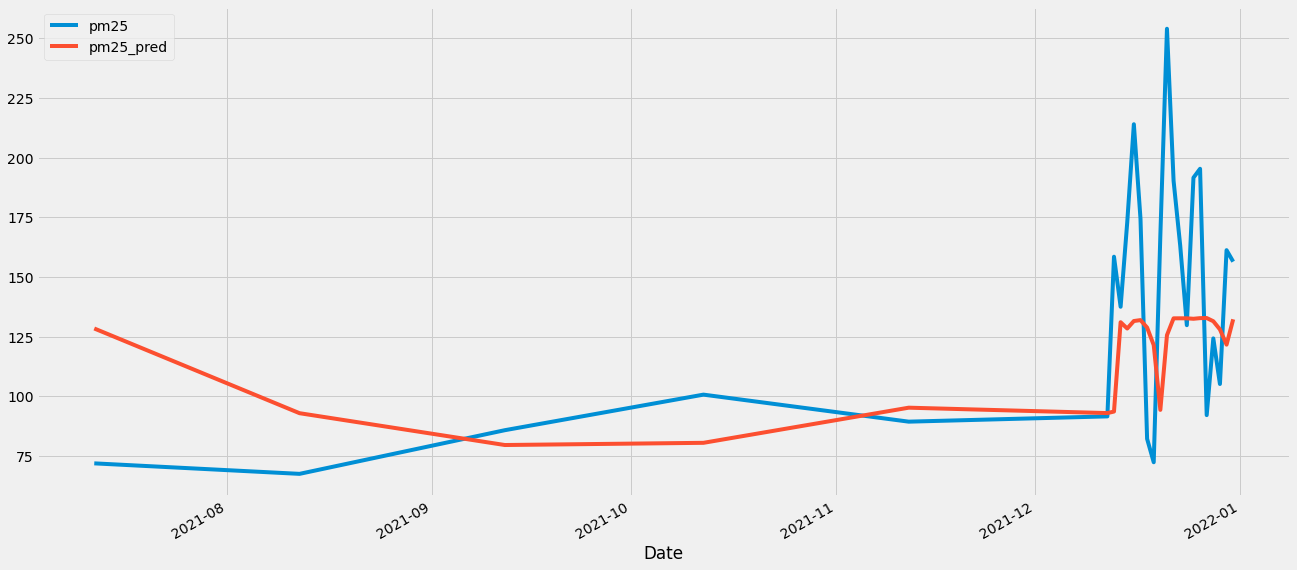

In [157]:
df_final[["pm25","pm25_pred"]].plot(figsize=(20,10))

In [158]:
model_CNN = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=256, kernel_size=2, activation=tf.keras.layers.LeakyReLU(alpha=0.3), input_shape=(win_length, num_features)),
    tf.keras.layers.Conv1D(filters=128, kernel_size=2, activation=tf.keras.layers.LeakyReLU(alpha=0.3)),
    tf.keras.layers.MaxPooling1D(pool_size=1),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(targets.shape[1])
])

model_CNN.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001),loss=tf.losses.MeanSquaredLogarithmicError())

tf.keras.utils.plot_model(model=model_CNN, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [159]:
lr_monitor = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.5, cooldown=1)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True)

with tf.device('/GPU:0'):
    prepared_model_CNN = model_CNN.fit(train_generator, 
                                       validation_data=val_generator,
                                       epochs=400, 
                                       shuffle=False,  
                                       callbacks=[lr_monitor, early_stopping])

Epoch 1/400
71/71 [==============================] - 1s 4ms/step - loss: 6.3625 - val_loss: 1.5349 - lr: 0.0010
Epoch 2/400
71/71 [==============================] - 0s 2ms/step - loss: 0.4176 - val_loss: 0.5307 - lr: 0.0010
Epoch 3/400
71/71 [==============================] - 0s 2ms/step - loss: 0.2048 - val_loss: 0.3847 - lr: 0.0010
Epoch 4/400
71/71 [==============================] - 0s 2ms/step - loss: 0.1832 - val_loss: 0.3565 - lr: 0.0010
Epoch 5/400
71/71 [==============================] - 0s 2ms/step - loss: 0.1782 - val_loss: 0.3474 - lr: 0.0010
Epoch 6/400
71/71 [==============================] - 0s 2ms/step - loss: 0.1752 - val_loss: 0.3396 - lr: 0.0010
Epoch 7/400
71/71 [==============================] - 0s 2ms/step - loss: 0.1724 - val_loss: 0.3305 - lr: 0.0010
Epoch 8/400
71/71 [==============================] - 0s 2ms/step - loss: 0.1696 - val_loss: 0.3204 - lr: 0.0010
Epoch 9/400
71/71 [==============================] - 0s 2ms/step - loss: 0.1668 - val_loss: 0.3096 - lr:

Text(0, 0.5, 'mse score')

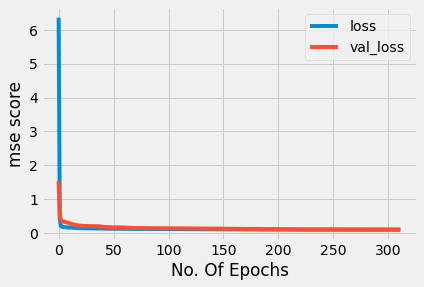

In [160]:
plt.plot(prepared_model_CNN.history["loss"],label="loss")
plt.plot(prepared_model_CNN.history["val_loss"],label="val_loss")
plt.legend(loc="best")
plt.xlabel("No. Of Epochs")
plt.ylabel("mse score")

In [161]:
model_CNN.evaluate(test_generator, verbose=1)

7/7 [==============================] - 0s 2ms/step - loss: 0.1288


0.1287570744752884

In [162]:
predictions=model_CNN.predict(test_generator)

pd.DataFrame(predictions)

7/7 [==============================] - 0s 1ms/step


,0
0,118.048073
1,93.944878
2,85.894447
3,92.240631
4,86.342003
5,95.369377
6,93.140984
7,125.093018
8,111.694496
9,147.324677


In [163]:
df_pred=pd.DataFrame(X_test[:,:][win_length:])

rev_trans=scaler.inverse_transform(df_pred)

df_final=df[rev_trans.shape[0]*-1:]
df_final

,pm25
Date,
2021-07-12,71.90
2021-08-12,67.50
2021-09-12,85.79
2021-10-12,100.69
2021-11-12,89.37
2021-12-12,91.58
2021-12-13,158.47
2021-12-14,137.51
2021-12-15,172.90


In [164]:
df_final[["pm25_pred"]]=predictions
df_final

,pm25,pm25_pred
Date,,
2021-07-12,71.90,118.048073
2021-08-12,67.50,93.944878
2021-09-12,85.79,85.894447
2021-10-12,100.69,92.240631
2021-11-12,89.37,86.342003
2021-12-12,91.58,95.369377
2021-12-13,158.47,93.140984
2021-12-14,137.51,125.093018
2021-12-15,172.90,111.694496


<AxesSubplot:xlabel='Date'>

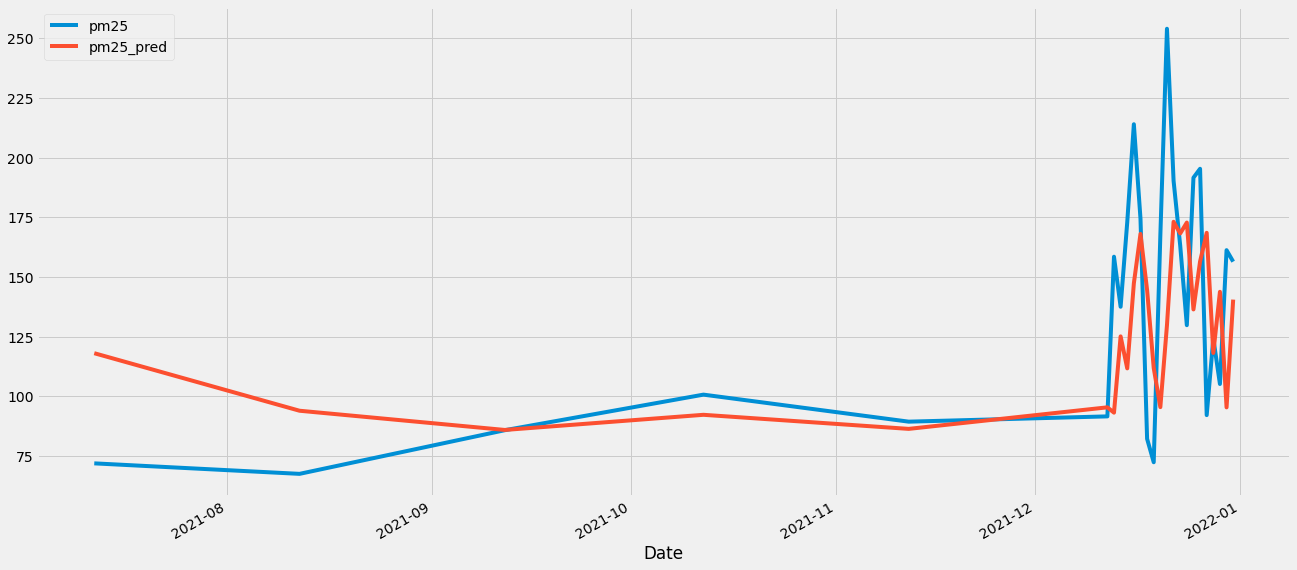

In [165]:
df_final[["pm25","pm25_pred"]].plot(figsize=(20,10))

In [166]:
model_CNNLSTM = tf.keras.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, return_sequences=True), input_shape=(win_length, num_features)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv1D(filters=128, kernel_size=2, activation=tf.keras.layers.LeakyReLU(alpha=0.7)),
    tf.keras.layers.MaxPooling1D(pool_size=1),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(targets.shape[1])
])

model_CNNLSTM.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001),loss=tf.losses.MeanSquaredLogarithmicError())

tf.keras.utils.plot_model(model=model_CNNLSTM, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [167]:
model_CNNLSTM.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_14 (Bidirecti  (None, 12, 200)          81600     
 onal)                                                           
                                                                 
 dropout_14 (Dropout)        (None, 12, 200)           0         
                                                                 
 conv1d_8 (Conv1D)           (None, 11, 128)           51328     
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 11, 128)          0         
 1D)                                                             
                                                                 
 flatten_5 (Flatten)         (None, 1408)              0         
                                                                 
 dense_11 (Dense)            (None, 1)               

In [168]:
lr_monitor = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.5, cooldown=1)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True)

with tf.device('/GPU:0'):
    prepared_model_CNNLSTM = model_CNNLSTM.fit(train_generator, 
                                       validation_data=val_generator,
                                       epochs=200, 
                                       shuffle=False,  
                                       callbacks=[lr_monitor, early_stopping])

Epoch 1/200
71/71 [==============================] - 3s 14ms/step - loss: 3.9025 - val_loss: 0.6911 - lr: 0.0010
Epoch 2/200
71/71 [==============================] - 0s 7ms/step - loss: 0.1772 - val_loss: 0.5594 - lr: 0.0010
Epoch 3/200
71/71 [==============================] - 0s 7ms/step - loss: 0.1563 - val_loss: 0.5083 - lr: 0.0010
Epoch 4/200
71/71 [==============================] - 1s 7ms/step - loss: 0.1525 - val_loss: 0.4948 - lr: 0.0010
Epoch 5/200
71/71 [==============================] - 0s 7ms/step - loss: 0.1460 - val_loss: 0.4809 - lr: 0.0010
Epoch 6/200
71/71 [==============================] - 0s 7ms/step - loss: 0.1459 - val_loss: 0.4783 - lr: 0.0010
Epoch 7/200
71/71 [==============================] - 0s 7ms/step - loss: 0.1415 - val_loss: 0.4733 - lr: 0.0010
Epoch 8/200
71/71 [==============================] - 1s 7ms/step - loss: 0.1420 - val_loss: 0.4774 - lr: 0.0010
Epoch 9/200
71/71 [==============================] - 0s 7ms/step - loss: 0.1368 - val_loss: 0.4640 - lr

Text(0, 0.5, 'mse score')

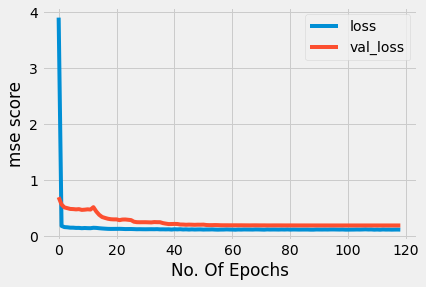

In [169]:
plt.plot(prepared_model_CNNLSTM.history["loss"],label="loss")
plt.plot(prepared_model_CNNLSTM.history["val_loss"],label="val_loss")
plt.legend(loc="best")
plt.xlabel("No. Of Epochs")
plt.ylabel("mse score")

In [170]:
model_CNNLSTM.evaluate(test_generator, verbose=1)

7/7 [==============================] - 0s 5ms/step - loss: 0.1250


0.12500068545341492

In [171]:
predictions=model_CNNLSTM.predict(test_generator)

pd.DataFrame(predictions)

7/7 [==============================] - 1s 6ms/step


,0
0,120.077042
1,107.280304
2,93.943619
3,91.414566
4,95.759811
5,94.322449
6,95.323868
7,117.210388
8,121.826866
9,131.510864


In [172]:
df_pred=pd.DataFrame(X_test[:,:][win_length:])

rev_trans=scaler.inverse_transform(df_pred)

df_final=df[rev_trans.shape[0]*-1:]

df_final[["pm25_pred"]]=predictions

df_final

,pm25,pm25_pred
Date,,
2021-07-12,71.90,120.077042
2021-08-12,67.50,107.280304
2021-09-12,85.79,93.943619
2021-10-12,100.69,91.414566
2021-11-12,89.37,95.759811
2021-12-12,91.58,94.322449
2021-12-13,158.47,95.323868
2021-12-14,137.51,117.210388
2021-12-15,172.90,121.826866


<AxesSubplot:xlabel='Date'>

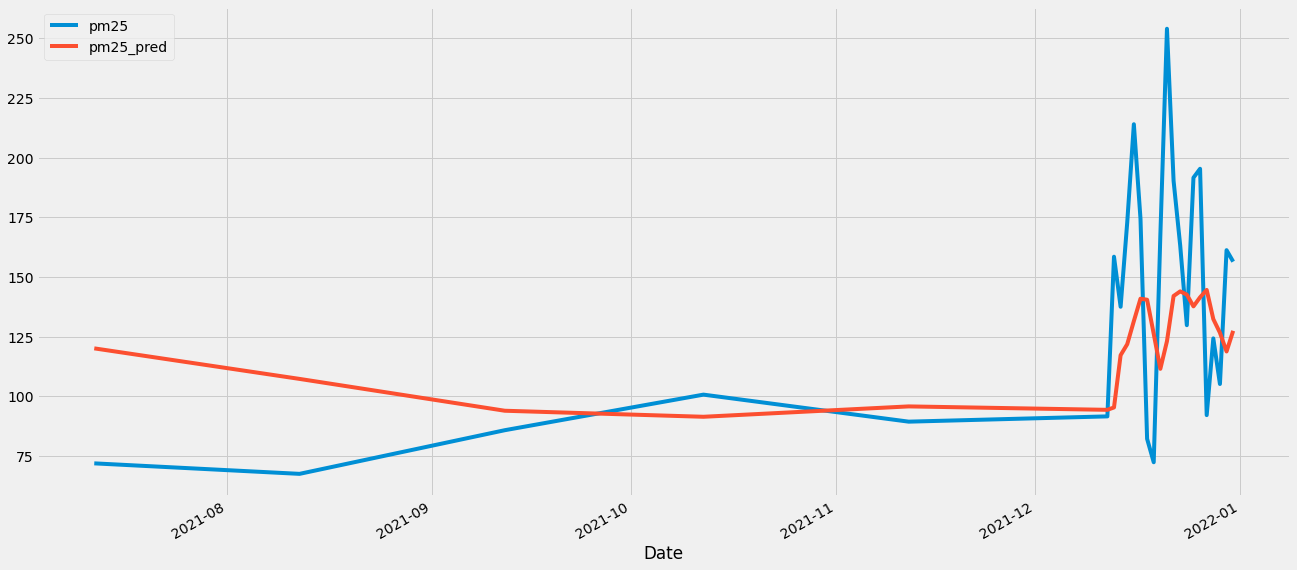

In [173]:
df_final[["pm25","pm25_pred"]].plot(figsize=(20,10))

In [174]:
def evaluate_preds(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    # Calculate various metrics
    mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
    mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
    rmse = tf.sqrt(mse)
    mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
    mslr = tf.keras.metrics.mean_squared_logarithmic_error(y_true, y_pred)
  
    return {"mae": mae.numpy(),
            "mse": mse.numpy(),
            "rmse": rmse.numpy(),
            "mape": mape.numpy(),
            "mslr": mslr.numpy(),
           }

In [175]:
selected_features = ["pm25"]

for feature in selected_features:
    print("-----{}-----".format(feature))
    print(evaluate_preds(y_true=df_final[feature].values,
                         y_pred=df_final["{}_pred".format(feature)].values)
         )

-----pm25-----
{'mae': 40.21141, 'mse': 2406.5933, 'rmse': 49.05704, 'mape': 30.331722, 'mslr': 0.12500067}
